In [1]:
pwd

'/Users/aidasaglinskas/Desktop/BC-FacExpr-1.2-fMRI-mainExp/scripts_python'

In [2]:
from matplotlib import pyplot as plt
from PIL import Image, ImageEnhance,ImageStat
import skvideo
import skvideo.io
import numpy as np
import os
from tqdm import tqdm
import alignfaces as afa
import cv2

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
def safe_mkdir(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)

In [4]:
def load_video(fn):
    #fn = 'ID4_h1_1.mp4'
    videodata = skvideo.io.vread(fn)
    return videodata

In [5]:
def save_video(videodata,ofn='outvideo.mp4'):
    skvideo.io.vwrite(ofn, videodata.astype(np.uint8),outputdict={'-codec': 'h264', '-filter:v' : 'fps=29.97'})

In [9]:
indir = '../stimuli/stimuli_raw/'
files = [os.path.join(indir,file) for file in os.listdir(indir) if file.endswith('.mp4')]
files.sort()
files[0:5]

['../stimuli/stimuli_raw/id1d1.mp4',
 '../stimuli/stimuli_raw/id1d2.mp4',
 '../stimuli/stimuli_raw/id1f1.mp4',
 '../stimuli/stimuli_raw/id1f2.mp4',
 '../stimuli/stimuli_raw/id1h1.mp4']

In [10]:
def split_into_frames(vid_fn):
    videodata = load_video(vid_fn)
    nframes = videodata.shape[0]
    frame_filenames = []
    for f in range(nframes):
        frame = videodata[f,:,:,:]
        frame_ofn = vid_fn.replace('.mp4','').replace('./stimuli/','./stimuli_pics/')+f'frame-{f}.png'
        frame_filenames.append(frame_ofn)
        Image.fromarray(frame).save(frame_ofn)
    return frame_filenames,videodata

In [11]:
do_split = False
if do_split:
    for file in tqdm(files):
        split_into_frames(file)

In [12]:
def get_video_frames(vid_fn):
    vid_name = vid_fn.split('/')[-1].replace('.mp4','')
    frames_bad = [i for i in os.listdir('./stimuli_pics/') if i.startswith(vid_name)]
    frames = [f'./stimuli_pics/{vid_name}frame-{i:01d}.png' for i in range(len(frames_bad))]
    return frames

In [13]:
def return_frame(image_fn,enlarge=0):
    
    trained_data = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    img = cv2.imread(image_fn)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cordinates = trained_data.detectMultiScale(gray_img)
    face_cordinates = face_cordinates + [-enlarge,-enlarge,enlarge*2,enlarge*2]
    
    return face_cordinates

In [14]:
 def crop_frame_to_rect(image_fn,rect,debug=False):
    img = cv2.imread(image_fn)
    img2 = cv2.imread(image_fn)
    for (x, y, w, h) in rect:
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 0), -2)
        
    img2[img!=0]=0

    if debug==False:
        return img2
    else:
        return img2,img

In [15]:
def rect_size(mean_frame):
    for (x, y, w, h) in rect:
        size = w*h
    return size

In [16]:
def save_cropped(frame_filenames,videodata,vid_ofn):
    mask = np.array([crop_frame(frame_filename)[1] for frame_filename in frame_filenames])
    vid_mask = ((mask==0).sum(-1)==3).sum(axis=0)>1    
    videodata_cropped = videodata.copy()
    nframes = videodata_cropped.shape[0]
    for f in range(nframes):
        for c in range(3):
            videodata_cropped[f,:,:,c][~vid_mask]=0
            
    save_video(videodata_cropped,ofn=vid_ofn)

In [17]:
def resize_video(video_data,vid_size_target=(512,512)):
    from PIL import Image, ImageEnhance,ImageStat
    import numpy as np
    
    #vid_size_target = np.array((512,512))
    vid_size_target = np.array(vid_size_target)
    vid_size = np.array((video_data.shape[1],video_data.shape[2]))
    nframes = video_data.shape[0]
    nchannels = video_data.shape[-1]
    video_data_new = np.zeros((nframes,vid_size_target[0],vid_size_target[1],nchannels))
    for f in range(nframes):
        video_data_new[f,:,:,:] = np.array(Image.fromarray(video_data[f,:,:,:]).resize(vid_size_target,Image.ANTIALIAS))

    return video_data_new

In [18]:
def resize_video(video_data,vid_size_target=(512,512)):
    from PIL import Image, ImageEnhance,ImageStat
    import numpy as np
    
    #vid_size_target = np.array((512,512))
    vid_size_target = np.array(vid_size_target)
    vid_size = np.array((video_data.shape[1],video_data.shape[2]))
    nframes = video_data.shape[0]
    nchannels = video_data.shape[-1]
    video_data_new = np.zeros((nframes,vid_size_target[0],vid_size_target[1],nchannels))
    for f in range(nframes):
        video_data_new[f,:,:,:] = np.array(Image.fromarray(video_data[f,:,:,:]).resize(vid_size_target[-1::-1],Image.ANTIALIAS))
        
    return video_data_new

In [19]:
def return_frame2(img,enlarge=0):
    
    trained_data = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    #img = cv2.imread(image_fn)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cordinates = trained_data.detectMultiScale(gray_img)
    face_cordinates = face_cordinates + [-enlarge,-enlarge,enlarge*2,enlarge*2]
    
    return face_cordinates

In [27]:
video_data.shape

(60, 720, 1280, 3)

In [28]:
vid_fn = files[0]
crop = 0
#frame_filenames = get_video_frames(vid_fn)
video_data = load_video(vid_fn)

#frame_filenames,video_data = split_into_frames(vid_fn)

#frame_rects = np.array([return_frame(frame_filename,enlarge=crop)[0] for frame_filename in frame_filenames])

frame_rects = np.array([return_frame2(video_data[i,:,:,:],enlarge=crop)[0] for i in range(video_data.shape[0])])
mean_frame = frame_rects.mean(axis=0).astype(int)

#c = [[mean_frame[0],mean_frame[1],256,256]]
c = [[mean_frame[0],mean_frame[1],mean_frame[2],mean_frame[3]]]

x = c[0][0] # - int(mean_frame[3]*.1)
y = c[0][1] # - int(mean_frame[3]*.15)
w = c[0][2] # + int(mean_frame[3]*.4)
h = c[0][3] # + int(mean_frame[3]*.4)

nframes = video_data.shape[0]
video_data_cropped = np.array([video_data[f,y:y+h,x:x+w,:] for f in range(nframes)])
video_data_cropped = resize_video(video_data_cropped,vid_size_target=(512,512))

ofn = vid_fn.replace('./stimuli/','./stimuli_cropped/')
ofn = ofn.replace('.mp4',f'_crop-{crop}.mp4')
#save_video(video_data_cropped,ofn)

[ERROR:0@250.843] global /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/core/src/persistence.cpp (505) open Can't open file: 'haarcascade_frontalface_default.xml' in read mode


error: OpenCV(4.6.0) /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/objdetect/src/cascadedetect.cpp:1689: error: (-215:Assertion failed) !empty() in function 'detectMultiScale'


In [21]:
do_crop = False
if do_crop:
    safe_mkdir('./stimuli_cropped')
    for vid_fn in tqdm(files[53::]):
        for crop in [0,10,20,30,40,50,60,70,80,90,100]:

            frame_filenames = get_video_frames(vid_fn)
            video_data = load_video(vid_fn)

            #frame_filenames,video_data = split_into_frames(vid_fn)

            frame_rects = np.array([return_frame(frame_filename,enlarge=crop)[0] for frame_filename in frame_filenames])
            mean_frame = frame_rects.mean(axis=0).astype(int)

            #c = [[mean_frame[0],mean_frame[1],256,256]]
            c = [[mean_frame[0],mean_frame[1],mean_frame[2],mean_frame[3]]]

            x = c[0][0] # - int(mean_frame[3]*.1)
            y = c[0][1] # - int(mean_frame[3]*.15)
            w = c[0][2] # + int(mean_frame[3]*.4)
            h = c[0][3] # + int(mean_frame[3]*.4)

            nframes = video_data.shape[0]
            video_data_cropped = np.array([video_data[f,y:y+h,x:x+w,:] for f in range(nframes)])
            video_data_cropped = resize_video(video_data_cropped,vid_size_target=(512,512))

            ofn = vid_fn.replace('./stimuli/','./stimuli_cropped/')
            ofn = ofn.replace('.mp4',f'_crop-{crop}.mp4')
            #save_video(video_data_cropped,ofn)

In [38]:
files_where = './stimuli_cropped'
files_which = [file for file in os.listdir(files_where) if file.endswith('.mp4')]
files_which.sort()
nfiles = len(files_which)
print(nfiles)
files_which[0:5]

770


['id1d1_crop-0.mp4',
 'id1d1_crop-10.mp4',
 'id1d1_crop-100.mp4',
 'id1d1_crop-20.mp4',
 'id1d1_crop-30.mp4']

In [39]:
def get_small_vid(i):
    return resize_video(load_video(os.path.join(files_where,files_which[i])),vid_size_target=(64,64)).mean(axis=-1).astype(np.uint8)

In [18]:
#flat_mat = np.array([load_video(os.path.join(files_where,files_which[i])).flatten()[0::1000] for i in tqdm(range(nfiles))])

In [55]:
flat_mat = np.array([get_small_vid(i)[0:50:2,:,:].flatten() for i in tqdm(range(nfiles))])

100%|█████████████████████████████████████████| 770/770 [03:43<00:00,  3.44it/s]


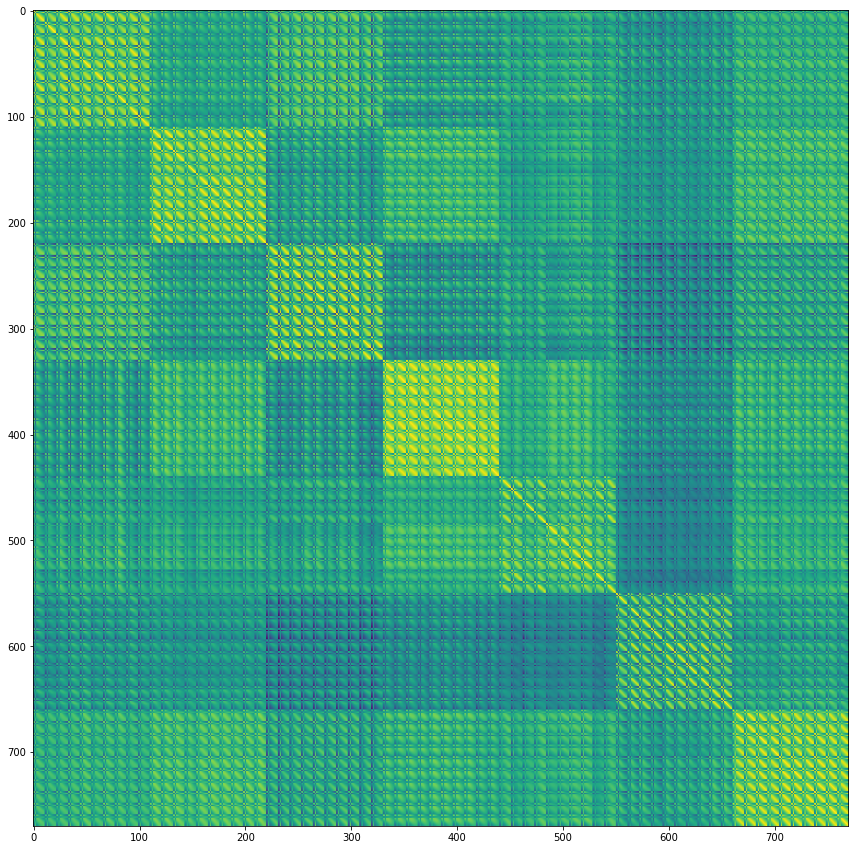

In [56]:
plt.figure(figsize=(15,15))
plt.imshow(np.corrcoef(flat_mat))

In [40]:
files = [os.path.join('./stimuli/',file) for file in os.listdir('./stimuli/') if file.endswith('.mp4')]
files.sort()
files[0:5]

['./stimuli/id1d1.mp4',
 './stimuli/id1d2.mp4',
 './stimuli/id1f1.mp4',
 './stimuli/id1f2.mp4',
 './stimuli/id1h1.mp4']

In [41]:
len(files)

70

In [42]:
def get_small_vid2(i,crop=0):
    return resize_video(load_video(files[i].replace('.mp4',f'_crop-{crop}.mp4').replace('./stimuli/','./stimuli_cropped/')),(128,128))[0:70:2,:,:,:].mean(axis=-1).astype(np.uint8)

In [45]:
def get_triu(inMat):
    #inMat = rdm_bg

    assert np.ndim(inMat)==2, 'not 2 dim, wtf'
    assert inMat.shape[0]==inMat.shape[1], 'not a square'

    n = inMat.shape[0]
    triu_vec = inMat[np.triu_indices(n=n,k=1)]

    #assert (squareform(triu_vec)==inMat).sum()/(n**2)>.9, 'unfaithful triu'
    return triu_vec


In [103]:
import random
cmat1 = np.corrcoef(np.array([get_small_vid2(i,crop=0).flatten() for i in tqdm(range(len(files)))]))
#cmat2 = np.corrcoef(np.array([get_small_vid2(i,crop=random.choice([0,10,20,30,40,50,60,70,80,90,100])).flatten() for i in tqdm(range(len(files)))]))
cmat2 = np.corrcoef(np.array([get_small_vid2(i,crop=random.choice([0,20,40,60,80])).flatten() for i in tqdm(range(len(files)))]))

100%|███████████████████████████████████████████| 70/70 [00:24<00:00,  2.86it/s]


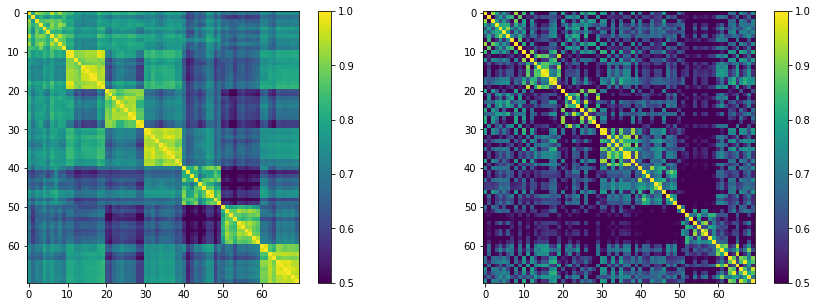

In [106]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(cmat1)
plt.clim(0.5,1)
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(cmat2)
plt.clim(0.5,1)
plt.colorbar()

In [113]:
get_triu(cmat1).mean()

0.7190666497230009

In [114]:
get_triu(cmat2).mean()

0.5729924405738648

In [107]:
ratios_cmat1 = []
for i in range(7):
    which_rows = np.arange(i*10,i*10+10)
    other_rows = np.array([i for i in np.arange(70) if i not in which_rows])
    within = get_triu(cmat1[which_rows,:][:,which_rows]).mean()
    across = cmat1[which_rows,:][:,other_rows].mean()
    ratio = within/across
    ratios_cmat1.append(ratio)
    
ratios_cmat2 = []
for i in range(7):
    which_rows = np.arange(i*10,i*10+10)
    other_rows = np.array([i for i in np.arange(70) if i not in which_rows])
    within = get_triu(cmat2[which_rows,:][:,which_rows]).mean()
    across = cmat2[which_rows,:][:,other_rows].mean()
    ratio = within/across
    ratios_cmat2.append(ratio)
    
ratios_cmat2 = np.array(ratios_cmat2)
ratios_cmat1 = np.array(ratios_cmat1)

In [108]:
print(ratios_cmat1.mean().round(2))
print(ratios_cmat2.mean().round(2))

1.29
1.25


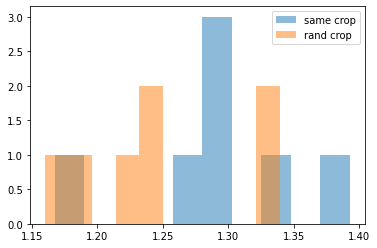

In [109]:
plt.hist(ratios_cmat1,alpha=.5)
plt.hist(ratios_cmat2,alpha=.5)
plt.legend(['same crop', 'rand crop'])

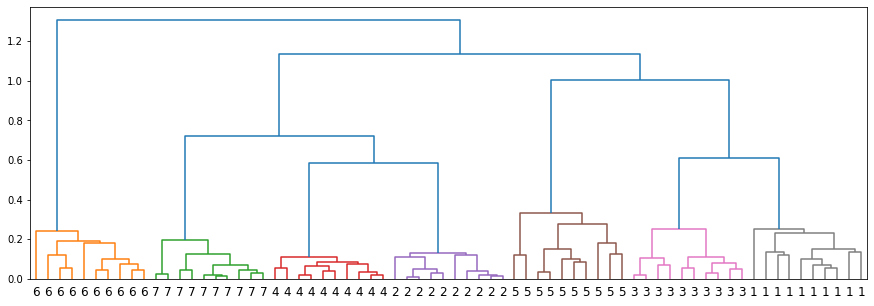

In [110]:
from scipy.cluster.hierarchy import linkage,dendrogram

Y = 1-get_triu(cmat1)
Z = linkage(Y,'ward')
lbls = [file.split('/')[-1].replace('.mp4','')[2] for file in files]
plt.figure(figsize=(15,5))
dendrogram(Z,0,labels=lbls,orientation='top',leaf_font_size=12,color_threshold=.5,leaf_rotation=0);

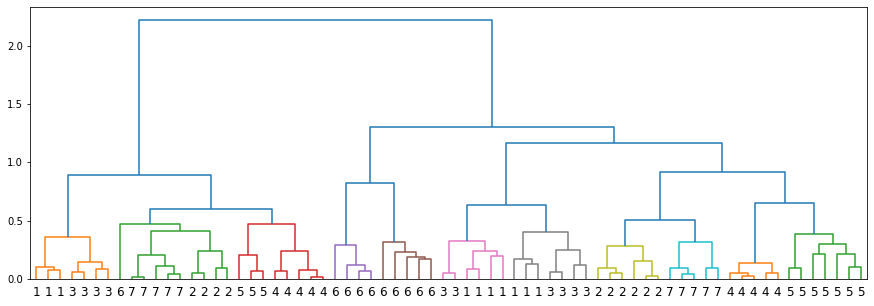

In [111]:
from scipy.cluster.hierarchy import linkage,dendrogram

Y = 1-get_triu(cmat2)
Z = linkage(Y,'ward')
lbls = [file.split('/')[-1].replace('.mp4','')[2] for file in files]
plt.figure(figsize=(15,5))
dendrogram(Z,0,labels=lbls,orientation='top',leaf_font_size=12,color_threshold=.5,leaf_rotation=0);